## Step 1 | GAN/Imports



In [2]:


!pip install tensorflow


     |████████████████████████████████| 458.4 MB 8.7 kB/s  eta 0:00:01
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
     |████████████████████████████████| 132 kB 19.5 MB/s eta 0:00:01
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 4.4 MB 32.0 MB/s eta 0:00:01
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
     |████████████████████████████████| 1.0 MB 22.5 MB/s eta 0:00:01
  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     |████████████████████████████████| 4.3 MB 12.8 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 462 kB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 20.1 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |█████████████████████

In [3]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output
import os


2021-09-01 17:51:14.735211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-01 17:51:14.735263: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 2 importing the images


In [4]:
#Replace the path replaced with Xs with the directory that the data file is stored in. 
#I added os.get_cwd() so people on different platforms can find the different formats of paths and adapt them to find the data.
# I reshaped all the photos into 100 by 100 pixels.
#and created a show_image function just to make sure everything is working properly.

import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(y/(1-y))
%matplotlib inline
path = '/home/leesalem/code/AliSalem2/data-challenges/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/data/Abstract_gallery'

os.getcwd()
img_list = os.listdir(path)
def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        img = Image.open(path+'/'+img_list[i],'r')
        basewidth = 100
        img = img.resize((basewidth,basewidth), Image.ANTIALIAS)
        pix = np.array(img.getdata())
        pixels.append(pix.reshape(100,100,3))
        imgs.append(img)
    return np.array(pixels),imgs
def show_image(pix_list):
    array = np.array(pix_list.reshape(100,100,3), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()


In [5]:
len(img_list)







2782

In [6]:
pixels,imgs = access_images(img_list,path,1000)
pixels.shape

(1000, 100, 100, 3)

In [7]:
os.getcwd()



'/home/leesalem/code/AliSalem2/GANsmania/notebooks'

In [9]:
os.getcwd()




'/home/leesalem/code/AliSalem2/GANsmania/notebooks'

 ## Step 3| Define Discriminator:
 


In [10]:
def define_discriminator(in_shape = (100,100,3)):
    #This discriminator takes in the list of fake and real images as input and returns a single value between 0 and 1. If the value is closer to 0, the computer thinks the image is real. If it comes closer to 1, the computer thinks the image is fake.

    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Step 4| Define Generator:




In [11]:
def define_generator(latent_dim):
    # The generator takes in a random point from latent space and takes it as an input. 
    # It upscales the latent point to the appropriate shape of 100,100,3, that can then be displayed as an image.
    model = Sequential()
    n_nodes = 128 * 25 * 25
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7) , padding='same'))
    return model

## Step 5| Define GAN:



In [12]:
def define_gan(g_model, d_model):
    # Linking the two models together gives the GAN, the complete model. The output of the generator is fed into the discriminator. It is then trained using these values.
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Step 6| Generate Parts:



In [13]:
def generate_real_samples(dataset, n_samples):
    #This calls upon the real and fake samples and generates the latent points that are used as the input for the generator.
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

## Step 7| Train:




In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
    
    #Remember that the two models are programmed to work against each other. 
    #During training, the computer will print out the loss for each of the models. 
    #Whichever value has the lowest loss is technically winning the competition. 
    #This allows you to see when the balance between both of the models is breaking down.
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    print(dataset.shape[0])
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

## Step 8| Summarize Performance:



In [15]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

After every epoch, this function will be called to show the loss and values for each epoch.
Step 9| Run Program:



In [19]:
pochs = np.array(pixels)
pochs.shape




(1000, 100, 100, 3)

In [21]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim, n_epochs=2)

print(pixels)


2021-09-01 17:58:10.303709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-01 17:58:10.303842: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-01 17:58:10.304063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-SGRBSEUC): /proc/driver/nvidia/version does not exist
2021-09-01 17:58:10.305532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/leesalem/.pyenv/versions/3.8.6/envs/GANsmania/lib/python3.8/site-packages/keras/optimizer_v2/

(1000, 100, 100, 3)
1000


2021-09-01 17:58:11.196525: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


>1, 1/100, d=26.455, g=0.692
>1, 2/100, d=0.348, g=0.692
>1, 3/100, d=0.350, g=0.688
>1, 4/100, d=0.351, g=0.685
>1, 5/100, d=0.352, g=0.681
>1, 6/100, d=0.358, g=0.672
>1, 7/100, d=0.361, g=0.668
>1, 8/100, d=0.368, g=0.656
>1, 9/100, d=0.379, g=0.641
>1, 10/100, d=0.384, g=0.624
>1, 11/100, d=0.393, g=0.603
>1, 12/100, d=0.434, g=0.579
>1, 13/100, d=0.434, g=0.539
>1, 14/100, d=0.457, g=0.469
>1, 15/100, d=0.512, g=0.469
>1, 16/100, d=0.535, g=0.486
>1, 17/100, d=0.666, g=0.397
>1, 18/100, d=0.601, g=0.305
>1, 19/100, d=0.622, g=0.391
>1, 20/100, d=0.606, g=0.313
>1, 21/100, d=0.739, g=0.408
>1, 22/100, d=5.715, g=0.305
>1, 23/100, d=1.015, g=0.293
>1, 24/100, d=1.224, g=0.148
>1, 25/100, d=1.376, g=0.182
>1, 26/100, d=3.904, g=0.088
>1, 27/100, d=1.708, g=0.033
>1, 28/100, d=1.891, g=0.044
>1, 29/100, d=2.290, g=0.026
>1, 30/100, d=1.858, g=0.174
>1, 31/100, d=2.010, g=0.255
>1, 32/100, d=2.705, g=0.041
>1, 33/100, d=1.239, g=0.178
>1, 34/100, d=3.906, g=0.012
>1, 35/100, d=2.783, g

## Step 10| Visualize Image generations:



In [22]:
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [23]:
import matplotlib.pyplot as plt


In [24]:
#This script actually runs the program. 
#For perspective on computation time, I use a windows surface pro.100 epochs takes 
#about 2 hours for a batch_size as defined in the code above.


In [25]:
model = g_model
latent_points = generate_latent_points(100,1)
X = model.predict(latent_points)
array = np.array(X.reshape(100,100,3), dtype=np.uint8)
new_image = Image.fromarray(array)
new_image.show()




display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/432.


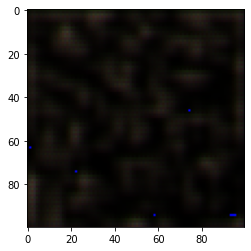

In [26]:
plt.imshow(new_image)


